In [1]:
# get dataset from huggingface hub
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
# !apt-get install git-lfs
# !git lfs install
# !git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
# !apt-get install unzip
# !unzip ./MLHW_6/faces.zip -d .


In [2]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm

# to(device)
os.environ['CUDA_VISIBLE_DEVICE']='5'
# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2022)
workspace_dir = '.'

In [ ]:

 i=5
 device =torch.device(f'cuda:{i}')
 # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 print(f"[Info]: Use {device} now!")


In [3]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


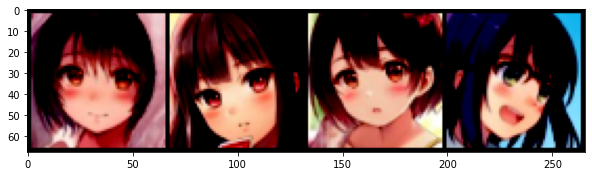

In [4]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [5]:
# Generator

class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super().__init__()
    
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   #(batch, feature_dim * 16, 32, 32)     
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [6]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            # nn.Sigmoid() 
        )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        Use nn.InstanceNorm2d instead
        """

        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            # nn.BatchNorm2d(out_dim),
            nn.InstanceNorm2d(out_dim),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y

In [7]:
# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
class TrainerGAN():
    def __init__(self, config):
        self.config = config
        
        self.G = Generator(100)
        self.D = Discriminator(3)
        
        self.loss = nn.BCELoss()

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer 
        """
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).to(device)
        
    def prepare_environment(self):
        """
        Use this funciton to prepare function
        """
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # create dataset by the above function
        dataset = get_dataset(os.path.join(self.config["workspace_dir"], 'faces'))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)
        
        # model preparation
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        self.G.train()
        self.D.train()
    def gp(self, r_imgs, f_imgs):
        """
        Implement gradient penalty function
        """
        Tensor=torch.cuda.FloatTensor
        alpha=Tensor(np.random.random((r_imgs.size(0),1,1,1)))
        interpolates=(alpha*r_imgs+(1-alpha)*f_imgs).requires_grad_(True)
        d_interpolates=self.D(interpolates)
        fake=Variable(Tensor(r_imgs.shape[0]).fill_(1.0),requires_grad=False)
        gradients=autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients=gradients.view(gradients.size(0),-1)
        gradient_penalty=((gradients.norm(1,dim=1)-1)**2).mean()
        return gradient_penalty
        pass
        
    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_environment()
        
        for e, epoch in enumerate(range(self.config["n_epoch"])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.to(device)
                bs = imgs.size(0)

                # *********************
                # *    Train D        *
                # *********************
                z = Variable(torch.randn(bs, self.config["z_dim"])).to(device)
                r_imgs = Variable(imgs).to(device)
                f_imgs = self.G(z)
                # r_label = torch.ones((bs)).to(device)
                # f_label = torch.zeros((bs)).to(device)


                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)

                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:
                
                GAN: 
                    loss_D = (r_loss + f_loss)/2
                WGAN: 
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP: 
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                # Loss for discriminator
                gradient_penalty=self.gp(r_imgs,f_imgs)
                loss_D=-torch.mean(r_logit)+torch.mean(f_logit)+gradient_penalty
                # r_loss = self.loss(r_logit, r_label)
                # f_loss = self.loss(f_logit, f_label)
                # loss_D = (r_loss + f_loss) / 2

                # Discriminator backwarding
                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                """
                NOTE FOR SETTING WEIGHT CLIP:
                
                WGAN: below code
                """
                # for p in self.D.parameters():
                #     p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])



                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    # Generate some fake images.
                    z = Variable(torch.randn(bs, self.config["z_dim"])).to(device)
                    f_imgs = self.G(z)

                    # Generator forwarding
                    f_logit = self.D(f_imgs)


                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:
                    
                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # Loss for the generator.
                    # loss_G = self.loss(f_logit, r_label)
                    loss_G=-torch.mean(self.D(f_imgs))

                    # Generator backwarding
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0
            filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
            torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
            logging.info(f'Save some samples to {filename}.')

            # Show some images during training.
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

            self.G.train()

            if (e+1) % 5 == 0 or e == 0:
                # Save the checkpoints.
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))

        logging.info('Finish training')

    def inference(self, G_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """

        self.G.load_state_dict(torch.load(G_path))
        self.G.to(device)
        self.G.eval()
        z = Variable(torch.randn(n_generate, self.config["z_dim"])).to(device)
        imgs = (self.G(z).data + 1) / 2.0
        
        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        
        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()


In [9]:
config = {
    "model_type": "WGANGP",
    "batch_size": 8,
    "lr": 1e-4,
    "n_epoch": 100,
    "n_critic": 2,
    "z_dim": 100,
    "workspace_dir": workspace_dir, # define in the environment setting,
    "clip_value":1
}

Epoch 1: 100%|██████████| 8915/8915 [04:48<00:00, 30.95it/s, loss_D=0.373, loss_G=-1.07] 
2022-04-23 15:15 - INFO: Save some samples to ./logs/2022-04-23_15-10-42_WGANGP/Epoch_001.jpg.


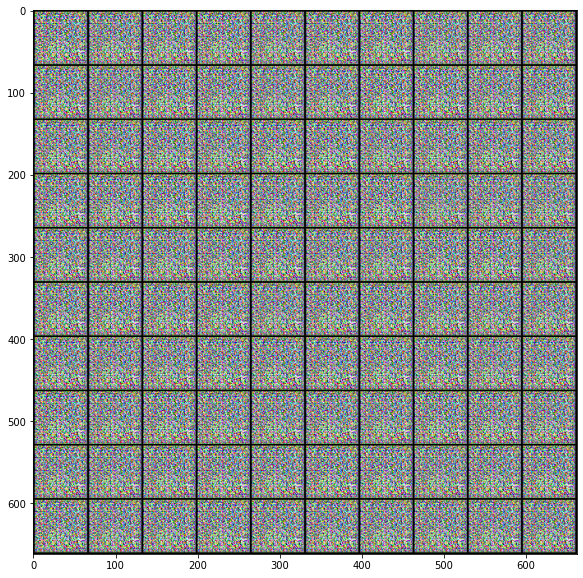

Epoch 2: 100%|██████████| 8915/8915 [05:15<00:00, 28.25it/s, loss_D=-.0771, loss_G=0.643]  
2022-04-23 15:20 - INFO: Save some samples to ./logs/2022-04-23_15-10-42_WGANGP/Epoch_002.jpg.


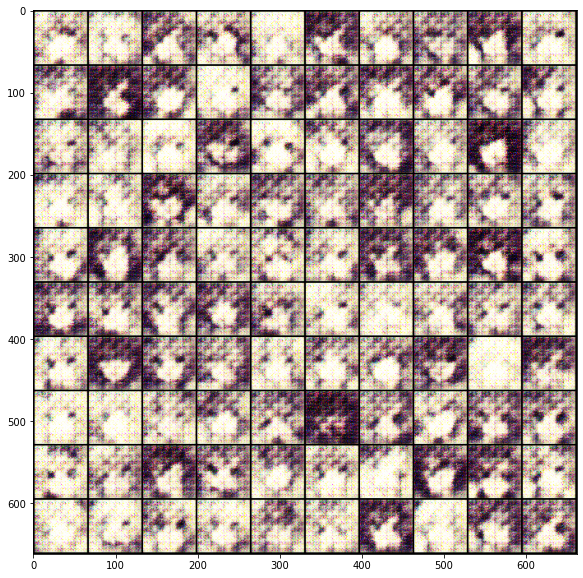

Epoch 3: 100%|██████████| 8915/8915 [05:19<00:00, 27.94it/s, loss_D=-.0605, loss_G=1.58]  
2022-04-23 15:26 - INFO: Save some samples to ./logs/2022-04-23_15-10-42_WGANGP/Epoch_003.jpg.


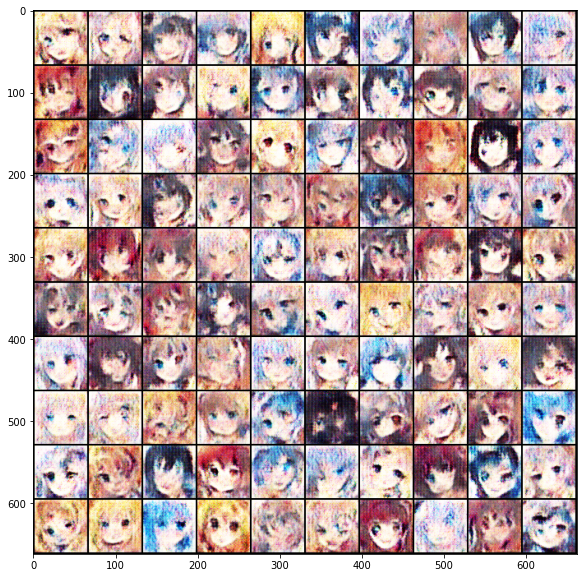

Epoch 5:  48%|████▊     | 4298/8915 [02:36<02:41, 28.66it/s, loss_D=-.0559, loss_G=1.23] 

In [ ]:
trainer = TrainerGAN(config)
trainer.train()

In [ ]:
# save the 1000 images into ./output folder
trainer.inference(f'{workspace_dir}/checkpoints/2022-03-31_15-59-17_GAN/G_0.pth') # you have to modify the path when running this line